In [4]:
import cv2
from bovw import BOVW
import pandas
from typing import *
from PIL import Image
import matplotlib.pyplot as plt 
from main import Dataset, run_final_pipeline, run_BOVW_experiment
from IPython.display import clear_output

Loading the data

In [5]:
print("Loading Train Dataset...")
data_train = Dataset(ImageFolder="../places_reduced/train")

print("Loading Test Dataset...")
data_test = Dataset(ImageFolder="../places_reduced/val")

Loading Train Dataset...
Loading Test Dataset...


Camell


#### Run the entire suit of tests and save them to final_experiment_results.csv

In [ ]:
# run_final_pipeline(data_train, data_test) # Uncomment for delivery

#### Loading the results csv from previous executions

In [6]:
results = pandas.read_csv("final_experiment_results.csv")

#### Results of the first experiment

In [7]:
print(results[results["Experiment"] == "Classifiers"])

    Experiment Parameter       Value  Classifier  Train_Accuracy  CV_Accuracy  \
0  Classifiers      Type     log_reg     log_reg        0.363417     0.284545   
1  Classifiers      Type  svm_linear  svm_linear        0.349851     0.271095   
2  Classifiers      Type     svm_rbf     svm_rbf        0.596114     0.301675   
3  Classifiers      Type          rf          rf        1.000000     0.247870   

     CV_Std  Test_Accuracy  
0  0.022446       0.303182  
1  0.011908       0.291818  
2  0.017618       0.340000  
3  0.013414       0.272727  


#### Running a given experiment and keeping the labels for qualitative results

In [18]:
classifiers = ["log_reg", "svm_linear", "svm_rbf", "rf"]
experiment_one_acc = {}
experiment_one_data = {}

for clf in classifiers:
    print("Running classifier", clf)
    bovw = BOVW(detector_type="SIFT", codebook_size=128)
    experiment_one_acc[clf], experiment_one_data[clf] = run_BOVW_experiment(bovw,data_train,data_test, clf_name=clf)

clear_output()
print("Experiment 1 succesfull")

Experiment 1 succesfull


,Value,CV_Accuracy,Test_Accuracy
13,32,0.252468,0.277727
14,64,0.264195,0.272273
15,128,0.272012,0.309545
16,256,0.271092,0.303636
17,512,0.274887,0.298182


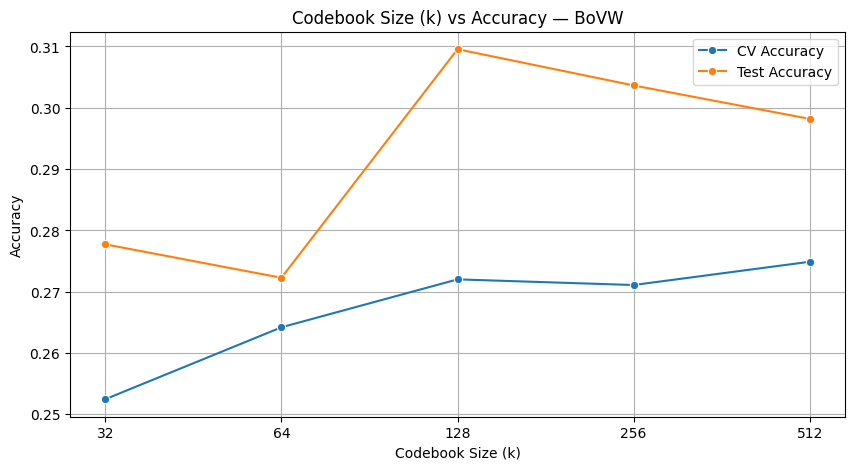


Best performing codebook size:


Experiment        Codebook Size
Parameter                     k
Value                       128
Classifier           svm_linear
Train_Accuracy         0.355254
CV_Accuracy            0.272012
CV_Std                 0.017625
Test_Accuracy          0.309545
Name: 15, dtype: object


Conclusion: k=128 gives best performance (Test Accuracy = 0.3095).


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_k = results[results["Experiment"] == "Codebook Size"].copy()


display(df_k[["Value", "CV_Accuracy", "Test_Accuracy"]])

plt.figure(figsize=(10,5))
sns.lineplot(x=df_k["Value"], y=df_k["CV_Accuracy"], marker="o", label="CV Accuracy")
sns.lineplot(x=df_k["Value"], y=df_k["Test_Accuracy"], marker="o", label="Test Accuracy")
plt.title("Codebook Size (k) vs Accuracy — BoVW")
plt.xlabel("Codebook Size (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

best = df_k.loc[df_k["Test_Accuracy"].idxmax()]
print("\nBest performing codebook size:")
display(best)

print(f"\nConclusion: k={best['Value']} gives best performance "
        f"(Test Accuracy = {best['Test_Accuracy']:.4f}).")


Loaded Fisher Vector results:


,timestamp,detector,K,n_train_images,n_test_images,cv_mean_acc,cv_std_acc,test_acc
0,2025-12-09 01:03:47.334841,DENSE_SIFT,32,8700,2200,0.310345,0.018946,0.355909
1,2025-12-09 01:08:07.717543,DENSE_SIFT,64,8700,2200,0.322644,0.007320,0.371364
2,2025-12-09 01:13:12.331835,DENSE_SIFT,128,8700,2200,0.333908,0.008955,0.375000



Best BoVW configuration:


Experiment        Codebook Size
Parameter                     k
Value                       128
Classifier           svm_linear
Train_Accuracy         0.355254
CV_Accuracy            0.272012
CV_Std                 0.017625
Test_Accuracy          0.309545
Name: 15, dtype: object

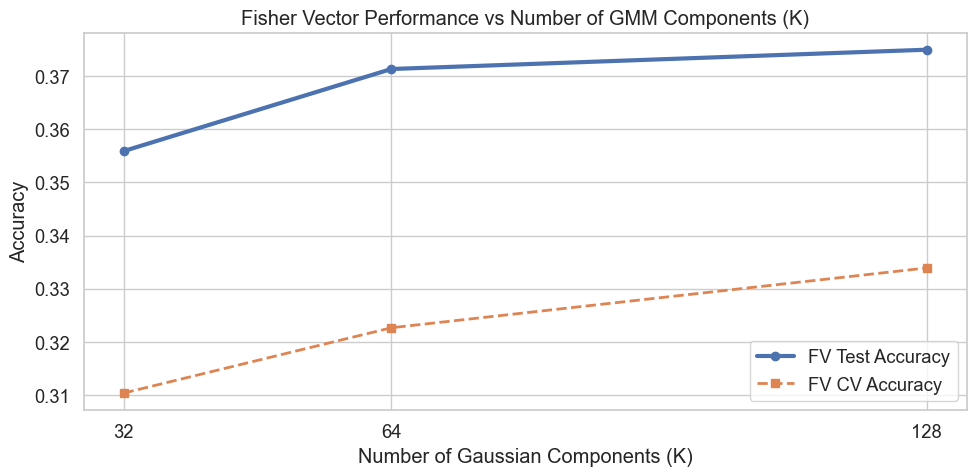

Merged Accuracy Table:


,K,BoVW_Accuracy,FV_Accuracy
0,32,0.277727,0.355909
1,64,0.272273,0.371364
2,128,0.309545,0.375000
3,256,0.303636,NaN
4,512,0.298182,NaN


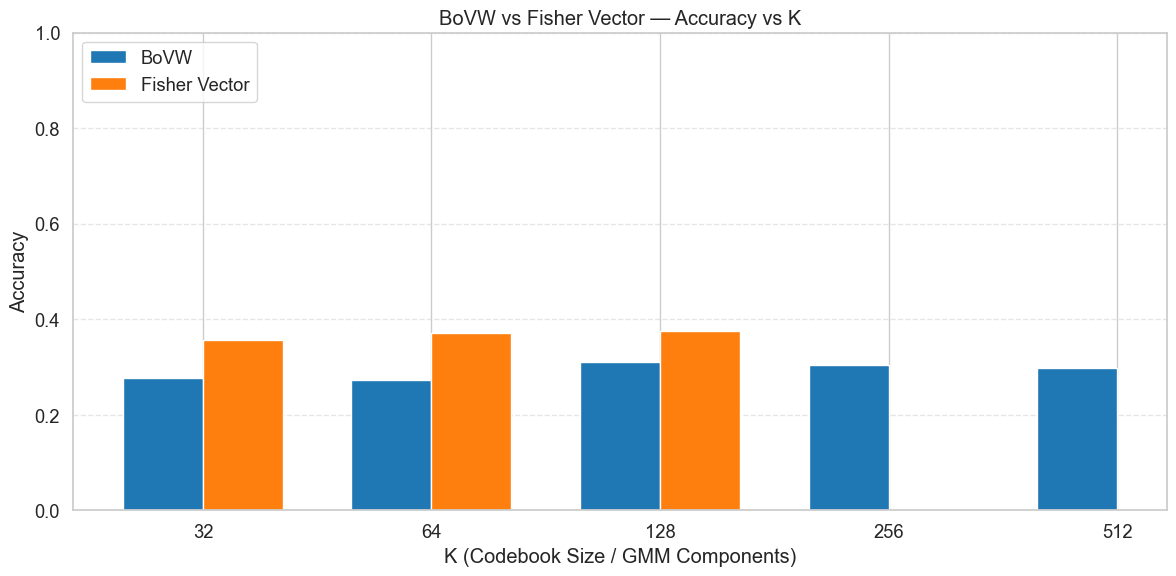

In [10]:
sns.set(style="whitegrid", font_scale=1.2)

# Load FV results
df_fv = pd.read_csv("fisher_vector_results.csv")
print("Loaded Fisher Vector results:")
display(df_fv)


# Load BoVW (Codebook Size) results for comparison
df_k = results[results["Experiment"] == "Codebook Size"].copy()


# Only test accuracy is needed for comparison
bovw_best = df_k.loc[df_k["Test_Accuracy"].idxmax()]
print("\nBest BoVW configuration:")
display(bovw_best)


# 1) Fisher Vector Trend Plot

plt.figure(figsize=(10,5))
plt.plot(df_fv["K"], df_fv["test_acc"], marker="o", linewidth=3, label="FV Test Accuracy")
plt.plot(df_fv["K"], df_fv["cv_mean_acc"], marker="s", linestyle="--", linewidth=2, label="FV CV Accuracy")

plt.title("Fisher Vector Performance vs Number of GMM Components (K)")
plt.xlabel("Number of Gaussian Components (K)")
plt.ylabel("Accuracy")
plt.xticks(df_fv["K"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Fisher Vector vs BoVW: Grouped Bar Plot (Accuracy vs K)


# Load FV and BoVW results

df_fv = pd.read_csv("fisher_vector_results.csv")
df_k = results[results["Experiment"] == "Codebook Size"].copy()


# Standardize column names

df_fv_small = df_fv[["K", "test_acc"]].rename(columns={"test_acc": "FV_Accuracy"})
df_bovw_small = df_k[["Value", "Test_Accuracy"]].rename(
    columns={"Value": "K", "Test_Accuracy": "BoVW_Accuracy"}
)


# Fix both Ks as integers

df_fv_small["K"] = pd.to_numeric(df_fv_small["K"], errors="coerce").astype("Int64")
df_bovw_small["K"] = pd.to_numeric(df_bovw_small["K"], errors="coerce").astype("Int64")


# Merge on K, outer join keeps all existing K values

df_merge = pd.merge(df_bovw_small, df_fv_small, on="K", how="outer").sort_values("K")

print("Merged Accuracy Table:")
display(df_merge)


# Plot: grouped bar chart

plt.figure(figsize=(12,6))

bar_width = 0.35
x = range(len(df_merge))

plt.bar(
    [p - bar_width/2 for p in x], 
    df_merge["BoVW_Accuracy"], 
    width=bar_width, 
    label="BoVW", 
    color="#1f77b4"
)

plt.bar(
    [p + bar_width/2 for p in x], 
    df_merge["FV_Accuracy"], 
    width=bar_width, 
    label="Fisher Vector", 
    color="#ff7f0e"
)

plt.xticks(x, df_merge["K"])
plt.xlabel("K (Codebook Size / GMM Components)")
plt.ylabel("Accuracy")
plt.title("BoVW vs Fisher Vector — Accuracy vs K")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


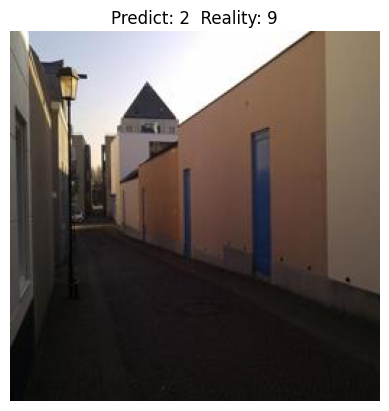

In [19]:
plt.title(f"Predict: {experiment_one_data[clf][0][0]}  Reality: {experiment_one_data[clf][0][1]}")
plt.imshow(data_test[0][0])
plt.axis("off")  # Hide axes for a cleaner look
plt.show()